In [3]:
library(car)
library(lmtest)
library(multcomp)
library(reshape)
library(MASS)
library(pwr)

v_experimentsData = readr::read_csv('C:/SSD_Gustavo/Repositories/GoTravel/Python/Data/Experiments/OptimizationExperiments.csv')

Parsed with column specification:
cols(
  .default = col_integer(),
  ChooseBestComponentProb = col_double(),
  CurrentSolutionInfluence = col_character(),
  DepositRate = col_double(),
  Distributed = col_character(),
  EvaporationRate = col_double(),
  `HV area` = col_double(),
  `HV at 60` = col_double(),
  HeuristicModifier = col_character(),
  ImprovedGetComponents = col_character(),
  LimitPheromones = col_character(),
  LocalSearchFinal = col_character(),
  LocalSearchSteps = col_character(),
  MinPheromoneLimitPercentage = col_character(),
  Name = col_character(),
  NeighbourhoodSize = col_double(),
  NumberGroups = col_double(),
  PheromoneModifier = col_character(),
  StartupTime = col_double(),
  instanceFile = col_character(),
  name = col_character()
  # ... with 2 more columns
)
See spec(...) for full column specifications.


In [2]:
## DATA EXPLORATION
names(v_experimentsData)



[1] "ChooseBestComponentProb"      "CurrentSolutionInfluence"    
 [3] "DepositRate"                  "Distributed"                 
 [5] "EvaporationRate"              "HV area"                     
 [7] "HV at 60"                     "HeuristicModifier"           
 [9] "ImprovedGetComponents"        "Iterations"                  
[11] "LimitPheromones"              "LocalSearchFinal"            
[13] "LocalSearchSteps"             "MaxStagnantGenerations"      
[15] "MinPheromoneLimitPercentage"  "MinimumParetoImprovement"    
[17] "Name"                         "NeighbourhoodSize"           
[19] "NumberAnts"                   "NumberGroups"                
[21] "PheromoneDefault"             "PheromoneModifier"           
[23] "StartupTime"                  "dateStartVariation"          
[25] "daysStayMaxDiff"              "experiment"                  
[27] "instanceFile"                 "iterationsWithoutImprovement"
[29] "maxOptimizationSeconds"       "maxStagnantGenerations"      
[31] "maxTransportWaitHours"        "name"                        
[33] "numberAccommodations"         "numberDestinations"          
[35] "numberTransports"             "ordered"                     
[37] "paretoApproximated"           "priceMaxAccommodationDay"    
[39] "priceMaxTransport"            "priceMinAccommodationDay"    
[41] "priceMinTransport"            "seed"

In [4]:
unique(v_experimentsData$ordered)
dim(v_experimentsData[v_experimentsData$paretoApproximated %in% c('True'), ])

[1] "False"

[1] 2435   42

## Prep Data

In [20]:
v_filteredData = v_experimentsData[v_experimentsData$PheromoneModifier %in% c('{\'cost\': 1, \'time\': 1}', '{\'0\': 1}'), ]
v_filteredData = v_filteredData[v_filteredData$HeuristicModifier %in% c('{\'cost\': 2, \'time\': 2}', '{\'0\': 2}'), ]
v_filteredData = v_filteredData[v_filteredData$NumberGroups %in% c(NA, 5), ]
v_filteredData = v_filteredData[v_filteredData$NeighbourhoodSize %in% c(NA, 4), ]
v_filteredData = v_filteredData[v_filteredData$numberDestinations %in% c(2,3,4,5,6,7), ]
v_filteredData = v_filteredData[v_filteredData$ordered %in% c('False'), ]

v_filteredData = v_filteredData[c('HV at 60', 'Iterations', 'StartupTime', 'Name', 'numberDestinations', 'LocalSearchSteps', 'Distributed', 'experiment')]
colnames(v_filteredData) <- c("hv60", 'iterations', 'startup', 'algorithm', 'destinations', 'localSearch', 'distributed', 'experiment')

v_filteredData[v_filteredData$localSearch %in% c(NA), 'localSearch'] = ''
v_filteredData[!v_filteredData$localSearch == '', 'localSearch'] = 'Local-search '

v_filteredData[v_filteredData$algorithm == 'OptimizerACO', 'algorithm'] = 'MOACO'
v_filteredData[v_filteredData$algorithm == 'OptimizerMOEAD_ACO', 'algorithm'] = 'MOEA/D-ACO'

v_filteredData[v_filteredData$distributed == 'False', 'distributed'] = ''
v_filteredData[v_filteredData$distributed == 'True', 'distributed'] = 'Distributed '

v_filteredData$algorithm = as.factor(v_filteredData$algorithm)
v_filteredData$localSearch = as.factor(v_filteredData$localSearch)
v_filteredData$distributed = as.factor(v_filteredData$distributed)

v_filteredData
# unique(v_filteredData$destinations)

hv60      iterations startup   algorithm  destinations localSearch  
1    0.9974286  39        1.8525350 MOEA/D-ACO 2                         
2    0.9998960  39        1.8551068 MOEA/D-ACO 2                         
3    0.9998289  39        1.8713095 MOEA/D-ACO 2                         
4    0.9999456  39        1.8363869 MOEA/D-ACO 2                         
5    0.9999859  39        1.8453116 MOEA/D-ACO 2                         
6    0.9974286  39        1.9027531 MOEA/D-ACO 2                         
7    0.9999597  39        1.8423445 MOEA/D-ACO 2                         
8    0.9974286  39        1.8175981 MOEA/D-ACO 2                         
9    1.0000000  39        1.8659062 MOEA/D-ACO 2                         
10   0.9999597  39        1.8354404 MOEA/D-ACO 2                         
11   0.9999060  38        1.8834198 MOEA/D-ACO 2                         
12   0.9998420  38        1.9344916 MOEA/D-ACO 2                         
13   0.9999859  39        1.8440006 MOEA/D-ACO 2                         
14   1.0000000  39        1.8882561 MOEA/D-ACO 2                         
15   0.9993215  39        1.8654644 MOEA/D-ACO 2                         
16   0.9974286  38        1.9411447 MOEA/D-ACO 2                         
17   1.0000000  38        1.8525176 MOEA/D-ACO 2                         
18   0.9968638  38        1.9149783 MOEA/D-ACO 2                         
19   0.9999597  38        1.9211879 MOEA/D-ACO 2                         
20   1.0000000  38        1.8946321 MOEA/D-ACO 2                         
21   1.0000000  38        1.9724302 MOEA/D-ACO 2                         
22   0.9999859  38        1.9177244 MOEA/D-ACO 2                         
23   0.9974286  38        1.8839831 MOEA/D-ACO 2                         
24   0.9998557  38        1.9149344 MOEA/D-ACO 2                         
25   0.9974286  38        2.0154459 MOEA/D-ACO 2                         
26   1.0000000 348        0.2575860 MOEA/D-ACO 2                         
27   0.9998919 344        0.2754834 MOEA/D-ACO 2                         
28   0.9998960 344        0.2593441 MOEA/D-ACO 2                         
29   0.9999456 341        0.2698755 MOEA/D-ACO 2                         
30   0.9999456 343        0.2622986 MOEA/D-ACO 2                         
...  ...       ...        ...       ...        ...          ...          
2561 1.0000000 36         1.9966769 MOEA/D-ACO 2            Local-search 
2562 1.0000000 36         2.0963979 MOEA/D-ACO 2            Local-search 
2563 1.0000000 36         1.9962058 MOEA/D-ACO 2            Local-search 
2564 1.0000000 36         1.9932082 MOEA/D-ACO 2            Local-search 
2565 0.9974286 36         1.9941089 MOEA/D-ACO 2            Local-search 
2566 1.0000000 82         1.0598102 MOEA/D-ACO 2            Local-search 
2567 1.0000000 83         0.9768114 MOEA/D-ACO 2            Local-search 
2568 1.0000000 83         0.9785185 MOEA/D-ACO 2            Local-search 
2569 1.0000000 85         1.0262740 MOEA/D-ACO 2            Local-search 
2570 1.0000000 83         0.9670224 MOEA/D-ACO 2            Local-search 
2571 1.0000000 82         1.0124927 MOEA/D-ACO 2            Local-search 
2572 1.0000000 83         0.9265609 MOEA/D-ACO 2            Local-search 
2573 1.0000000 83         0.9436924 MOEA/D-ACO 2            Local-search 
2574 1.0000000 83         1.0243428 MOEA/D-ACO 2            Local-search 
2575 1.0000000 83         0.9530101 MOEA/D-ACO 2            Local-search 
2576 1.0000000 81         0.9547293 MOEA/D-ACO 2            Local-search 
2577 1.0000000 82         0.8667102 MOEA/D-ACO 2            Local-search 
2578 1.0000000 84         0.8310292 MOEA/D-ACO 2            Local-search 
2579 1.0000000 83         0.9341443 MOEA/D-ACO 2            Local-search 
2580 1.0000000 83         1.0680397 MOEA/D-ACO 2            Local-search 
2581 1.0000000 82         0.9694974 MOEA/D-ACO 2            Local-search 
2582 1.0000000 82         0.9634483 MOEA/D-ACO 2            Local-search 
2583 1.00

In [47]:
v_dataSd = aggregate(cbind(hv60,iterations,startup)~destinations:algorithm:localSearch:distributed,data=v_filteredData, FUN=sd)

v_dataAgg = aggregate(cbind(hv60,iterations,startup)~destinations:algorithm:localSearch:distributed, data=v_filteredData, FUN=mean)

# v_dataSd
v_dataAgg


destinations algorithm  localSearch   distributed  hv60      iterations
1  2            MOACO                                 0.9972164 226.35000 
2  3            MOACO                                 0.9561803 179.05000 
3  4            MOACO                                 0.9481449 137.09231 
4  5            MOACO                                 0.8961622 109.66316 
5  6            MOACO                                 0.8852404 126.60000 
6  7            MOACO                                 0.8565884  96.08000 
7  2            MOEA/D-ACO                            0.9999499 343.36000 
8  3            MOEA/D-ACO                            0.9903586 270.52000 
9  4            MOEA/D-ACO                            0.9876817 243.90000 
10 5            MOEA/D-ACO                            0.9779900 260.05000 
11 6            MOEA/D-ACO                            0.9274221 124.69231 
12 7            MOEA/D-ACO                            0.9529904  97.75556 
13 2            MOACO      Local-search               1.0000000  78.65000 
14 3            MOACO      Local-search               0.9850659  48.76667 
15 4            MOACO      Local-search               0.9726753  30.31250 
16 5            MOACO      Local-search               0.9125413  16.46316 
17 6            MOACO      Local-search               0.8890449  14.27500 
18 7            MOACO      Local-search               0.8582173   9.74000 
19 2            MOEA/D-ACO Local-search               1.0000000  82.64000 
20 3            MOEA/D-ACO Local-search               0.9882999  71.77778 
21 4            MOEA/D-ACO Local-search               0.9825379  61.55385 
22 5            MOEA/D-ACO Local-search               0.9686716  66.66667 
23 6            MOEA/D-ACO Local-search               0.9229941  26.72222 
24 7            MOEA/D-ACO Local-search               0.9376103  20.22000 
25 2            MOACO                    Distributed  0.9999077  37.40000 
26 3            MOACO                    Distributed  0.9844017  37.13333 
27 4            MOACO                    Distributed  0.9580707  36.56667 
28 5            MOACO                    Distributed  0.8919704  34.90000 
29 6            MOACO                    Distributed  0.8697607  38.46667 
30 7            MOACO                    Distributed  0.8463242  33.42500 
31 2            MOEA/D-ACO               Distributed  0.9991947  38.52000 
32 3            MOEA/D-ACO               Distributed  0.9745479  38.88000 
33 4            MOEA/D-ACO               Distributed  0.9717012  38.60000 
34 5            MOEA/D-ACO               Distributed  0.9561153  38.05000 
35 6            MOEA/D-ACO               Distributed  0.9221846  44.87500 
36 7            MOEA/D-ACO               Distributed  0.9394235  40.94000 
37 2            MOACO      Local-search  Distributed  1.0000000  34.28000 
38 3            MOACO      Local-search  Distributed  0.9995948  31.97778 
39 4            MOACO      Local-search  Distributed  0.9840017  27.75556 
40 5            MOACO      Local-search  Distributed  0.9279146  24.88333 
41 6            MOACO      Local-search  Distributed  0.9046957  23.05000 
42 7            MOACO      Local-search  Distributed  0.8803446  18.76250 
43 2            MOEA/D-ACO Local-search  Distributed  0.9993829  36.88000 
44 3            MOEA/D-ACO Local-search  Distributed  0.9843907  37.15556 
45 4            MOEA/D-ACO Local-search  Distributed  0.9782532  35.71111 
46 5            MOEA/D-ACO Local-search  Distributed  0.9567395  35.23333 
47 6            MOEA/D-ACO Local-search  Distributed  0.9235581  37.35000 
48 7            MOEA/D-ACO Local-search  Distributed  0.9458411  32.26250 
   startup   
1   0.3894828
2   0.5177513
3   0.5610547
4   0.7423736
5   1.0362969
6   1.3680766
7   0.2659006
8   0.3052577
9   0.3788590
10  0.3503424
11  0.9071269
12  1.1777924
13  1.7729660
14  2.6389534
15  3.3438042
16  4.3775568
17  7.3812399
18 10.2604345
19  0.9714260
20  0.9920874
21  1.3294848
22  1.2425924
23  3.

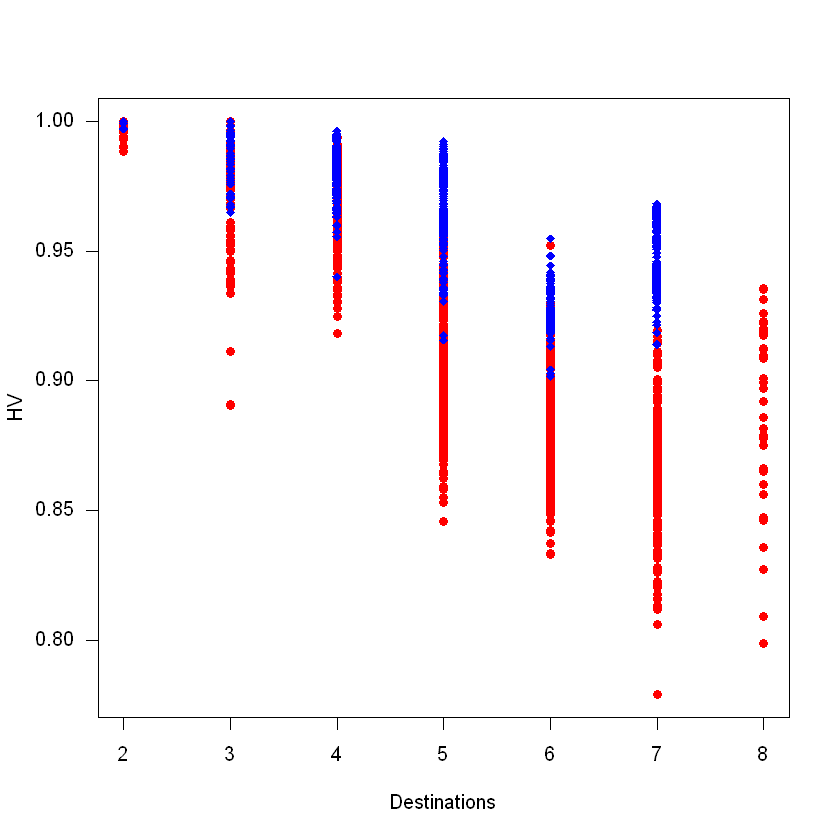

In [8]:
plot(x = subset(v_filteredData, algorithm=='MOACO')$destinations,
     y = subset(v_filteredData, algorithm=='MOACO')$hv60,
     cex  = 1,
     las  = 1,
     pch  = 16,
     col='red',
     xlab = "Destinations",
     ylab = "HV")

points(x = subset(v_filteredData, algorithm=='MOEA/D-ACO')$destinations,
     y = subset(v_filteredData, algorithm=='MOEA/D-ACO')$hv60,
     cex  = 1,
     pch  = 18,
     col='blue')

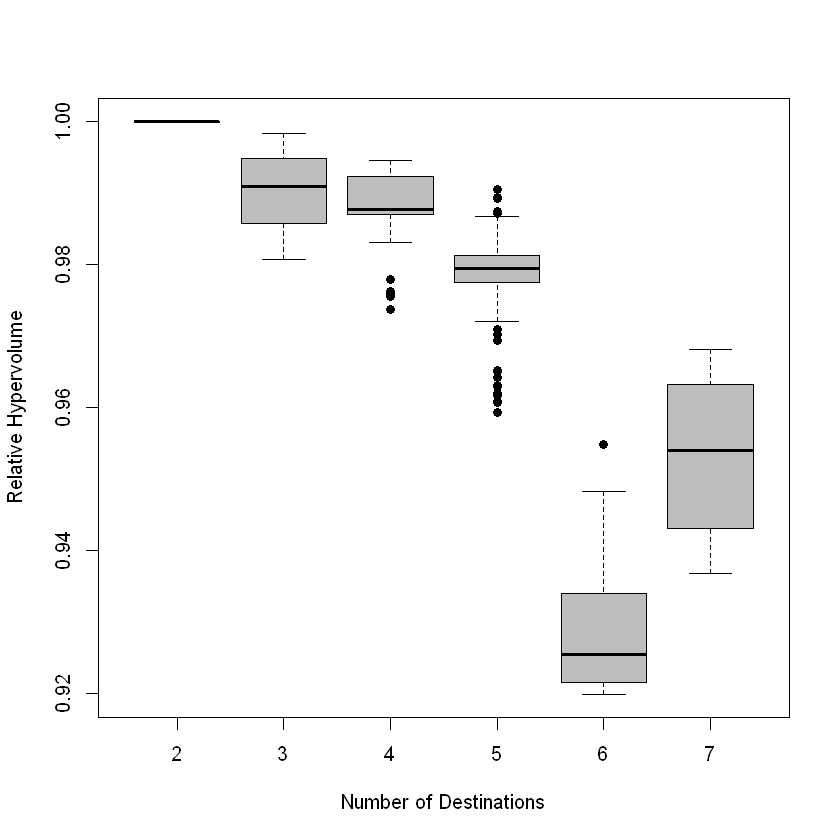

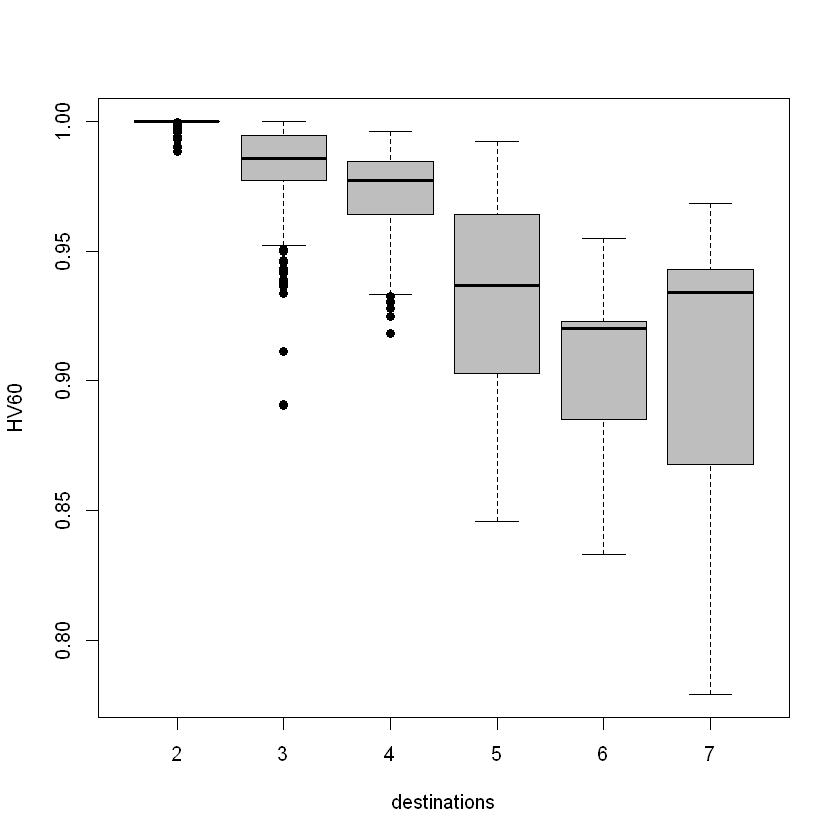

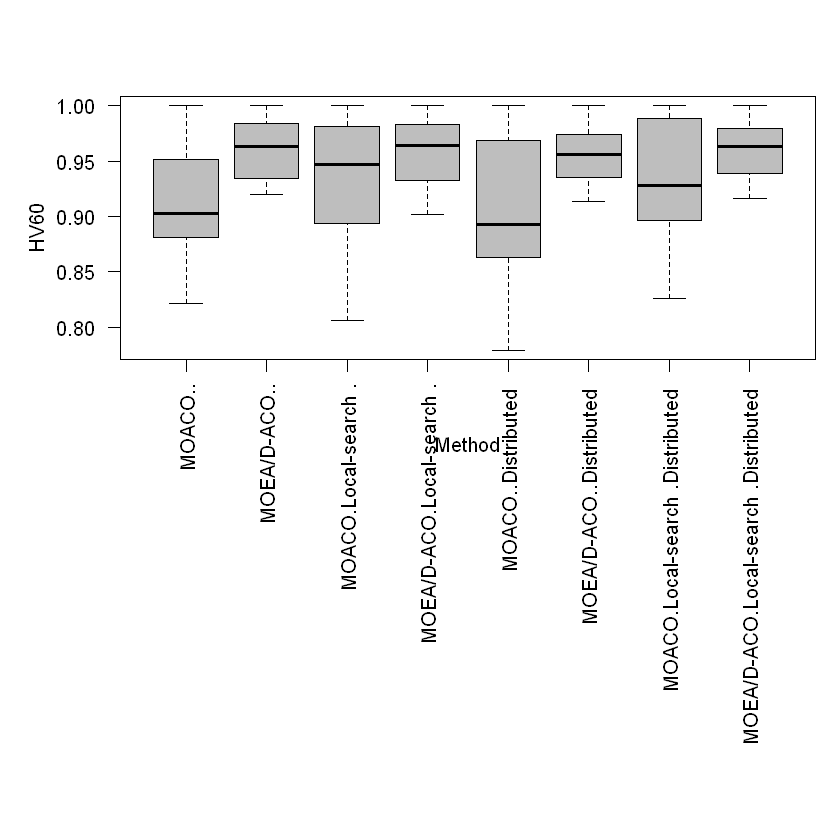

In [29]:
# hv

v_localMoacoData = v_filteredData[v_filteredData$algorithm == 'MOEA/D-ACO',]
# v_localMoacoData = v_localMoacoData[v_localMoacoData$localSearch == 'Local-search ', ]
# v_localMoacoData = v_localMoacoData[v_localMoacoData$distributed == 'Distributed ', ]

v_localMoacoData = v_localMoacoData[v_localMoacoData$localSearch == '', ]
v_localMoacoData = v_localMoacoData[v_localMoacoData$distributed == '', ]

 

boxplot(hv60~destinations,
        data = v_localMoacoData, 
        xlab = "Number of Destinations",
        ylab = "Relative Hypervolume", 
        main = "",
        pch  = 16,
        col  = "gray")

boxplot(hv60~destinations,
        data = v_filteredData, 
        xlab = "destinations",
        ylab = "HV60", 
        main = "",
        pch  = 16,
        col  = "gray")

par(mar=c(20,5,4,1))
boxplot(hv60~algorithm+localSearch+distributed,
        data = v_filteredData, 
        xlab = "Method",
        ylab = "HV60", 
        main = "",
        pch  = 16,
        las=2,
        col  = "gray")



               Df Sum Sq Mean Sq F value Pr(>F)    
algorithm       1 0.7718  0.7718    1367 <2e-16 ***
destinations    1 3.0770  3.0770    5449 <2e-16 ***
Residuals    2587 1.4607  0.0006                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Call:
aov(formula = hv60 ~ algorithm + destinations, data = v_filteredData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.096373 -0.017183 -0.000334  0.018067  0.054596 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.0306828  0.0015778  653.24   <2e-16 ***
algorithmMOEA/D-ACO  0.0406075  0.0009378   43.30   <2e-16 ***
destinations        -0.0221831  0.0003005  -73.82   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02376 on 2587 degrees of freedom
Multiple R-squared:  0.7249,	Adjusted R-squared:  0.7247 
F-statistic:  3408 on 2 and 2587 DF,  p-value: < 2.2e-16


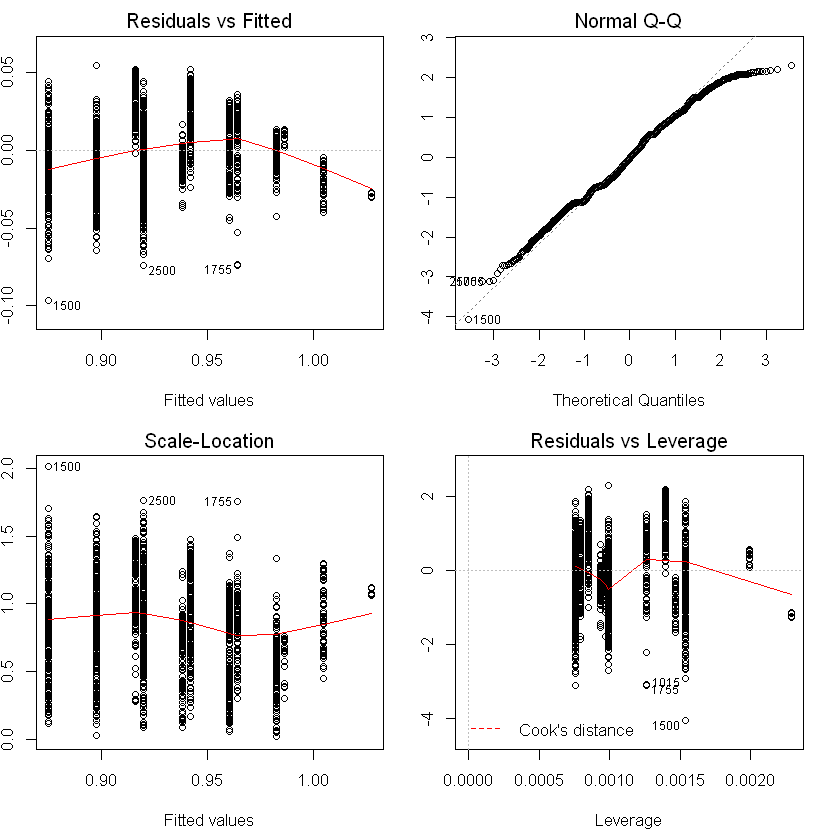

In [50]:
# v_anova <- aov(hv60~algorithm+as.factor(destinations), 
#                         data = v_filteredData)

v_anova <- aov(hv60~algorithm+destinations, 
                        data = v_filteredData)
summary.aov(v_anova)
summary.lm(v_anova)

par(mfrow=c(2,2), mai=.3*c(2.5,1,1,1))
plot(v_anova)

# v_tTestTime = t.test(hv60~algorithm,
#                     data=v_filteredData,
#                     mu = 0,
#                     conf.level = 0.95, 
#                     alternative = 'two.sided',
#                     paired=TRUE
# )
# v_tTestTime

# mudar de lugar
# Time - iteraction effects
# v_anova <- aov(hv60~algorithm*destinations, 
#                         data = v_filteredData)
# summary.aov(v_anova)
# summary.lm(v_anova)

# par(mfrow=c(2,2), mai=.3*c(2.5,1,1,1))
# plot(v_anova)

In [51]:
## ANOVA & MULTICOMP
v_alpha = 0.05
# v_a = length(unique(v_filteredData$algorithm))
v_a = 8
v_k = v_a*(v_a-1)/2
v_alphaAdj = v_alpha/v_k
v_beta = 0.2
v_power = 1-v_beta
v_delta = 0.01

v_powerAnova = pwr.anova.test(k = v_a, n = dim(v_filteredData)[1]/v_a, f = 0.1, sig.level = v_alpha)$power
print('PowerAnova:')
print(v_powerAnova)

# Welch Anova (accounting for heterocedascity)
oneway.test(hv60~algorithm+distributed+localSearch, data=v_filteredData, var.equal=FALSE)
# or
Anova(lm(hv60~algorithm+distributed+localSearch, data = v_filteredData), white.adjust = TRUE)


[1] "PowerAnova:"
[1] 0.978461



	One-way analysis of means (not assuming equal variances)

data:  hv60 and algorithm + distributed + localSearch
F = 81.827, num df = 7.0, denom df = 1059.9, p-value < 2.2e-16


Df   F          Pr(>F)      
algorithm      1 465.529311 4.471283e-95
distributed    1   1.806544 1.790413e-01
localSearch    1  77.095061 2.904159e-18
Residuals   2586         NA           NA

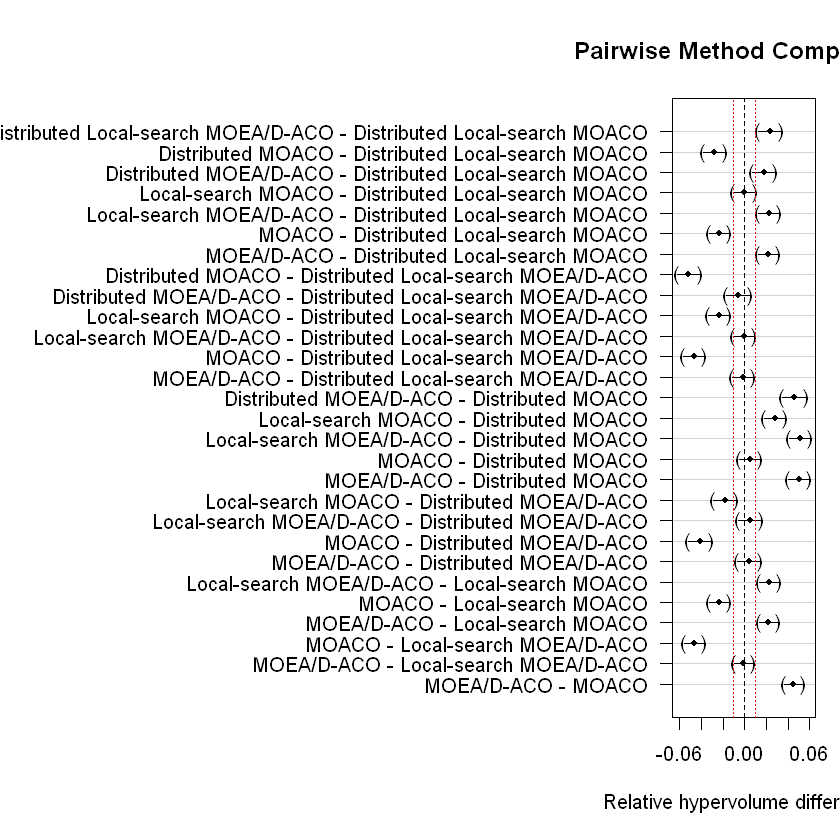

In [52]:
# Multiple comparison all-vs-all

v_dfMerged = v_filteredData
v_dfMerged$method = paste( v_dfMerged$distributed, v_dfMerged$localSearch, v_dfMerged$algorithm,  sep = "")
v_dfMerged$method = as.factor(v_dfMerged$method)

# v_dfMerged = v_dfMerged[v_dfMerged$destinations %in% c(6,7), ]
# v_dfMerged = v_dfMerged[v_dfMerged$algorithm == 'MOACO', ]

v_model <- lm(hv60~method,
               data = v_dfMerged)
v_tukey = glht(v_model, linfct=mcp(method = "Tukey"))
v_tukeyCI = confint(v_tukey, level=1-v_alpha)
par(mfrow=c(1,1), mar=c(5.1,28,4.1,1))
plot(v_tukeyCI, xlab = "Relative hypervolume difference", main='Pairwise Method Comparison')
abline(v=c(v_delta, -v_delta), col='red', lty=3)
par(mfrow=c(1,1), mar=c(5.1,4.1,4.1,2.1))

In [84]:
v_dataMergedFiltered = v_dfMerged[v_dfMerged$method %in% c('  MOACO', ' Loc MOACO'), ]

oneway.test(hv60~method+destinations, data=v_dataMergedFiltered, var.equal=TRUE)

Anova(lm(hv60~method+destinations, data = v_dataMergedFiltered), white.adjust = TRUE)


	One-way analysis of means

data:  hv60 and method + destinations
F = 561.13, num df = 11, denom df = 733, p-value < 2.2e-16


Df  F          Pr(>F)      
method         1   97.09128 1.309745e-21
destinations   1 4915.82251 0.000000e+00
Residuals    742         NA           NA